In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.1)

## Define the profile Schema

In [4]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """user profile schema with typed fields
    
    Args:
    user_name: is the user's preferred name,
    interests: is a list of users interests
    """
    user_name: str
    interests: List[str]

In [5]:

user_profile = UserProfile(user_name="Md Al Amin", interests=['biking', 'programming', 'reading'])
user_profile

{'user_name': 'Md Al Amin', 'interests': ['biking', 'programming', 'reading']}

In [6]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

user_id = '1'
namespace_for_memory = (user_id, 'memory')
key = "user_profile"
value = user_profile

in_memory_store.put(namespace_for_memory, key, value)

In [7]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Md Al Amin', 'interests': ['biking', 'programming', 'reading']}, 'created_at': '2025-05-19T10:28:32.517899+00:00', 'updated_at': '2025-05-19T10:28:32.517899+00:00', 'score': None}


In [12]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict()['value'])

{'user_name': 'Md Al Amin', 'interests': ['biking', 'programming', 'reading']}


In [13]:
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Md Al Amin', 'interests': ['biking', 'programming', 'reading']}

## LangGraph Tracking

In [14]:
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Trustcall for creating and updating profile schemas

As we can see, working with schemas can be tricky.

Complex schemas can be difficult to extract.

In addition, updating even simple schemas can pose challenges.

Consider our above chatbot.

We regenerated the profile schema *from scratch* each time we chose to save a new memory.

This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

Worse, we may loose information when regenerating the profile from scratch.

Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

It's motivated by exactly these challenges while working on memory.

Let's first show simple usage of extraction with TrustCall on this list of [messages](https://python.langchain.com/docs/concepts/messages/).


In [15]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage
# Conversation
conversation = [HumanMessage(content="Hi, I'm Al Amin."),
                AIMessage(content="Nice to meet you, Lance."),
                HumanMessage(content="I really like biking around Bashundhara r/a, Dhaka.")]

In [16]:
from pydantic import BaseModel, Field
from trustcall import create_extractor


# Schema
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")


# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

In [18]:
for m in result['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_qvt1)
 Call ID: call_qvt1
  Args:
    user_name: Al Amin
    interests: ['biking', 'Bashundhara r/a', 'Dhaka']


In [19]:
schema = result['responses']
schema

[UserProfile(user_name='Al Amin', interests=['biking', 'Bashundhara r/a', 'Dhaka'])]

In [20]:
schema[0].model_dump()

{'user_name': 'Al Amin', 'interests': ['biking', 'Bashundhara r/a', 'Dhaka']}

## Update the existing data

In [21]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Al Amin."),
                        AIMessage(content="Nice to meet you, Lance."),
                        HumanMessage(content="I really like biking around Bashundhara r/a, Dhaka."),
                        AIMessage(content="Bashundhara r/a, Dhaka. is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)

result = trustcall_extractor.invoke(
    {
        'messages': [SystemMessage(content=system_msg)]+updated_conversation
    },
    {
        "existing": {
            "UpdateProfile": schema[0].model_dump()
        }
    }
)

In [22]:
for m in result['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_666x)
 Call ID: call_666x
  Args:
    user_name: Al Amin
    interests: ['biking', 'bakery', 'Bashundhara r/a, Dhaka.']


In [24]:
result['responses'][0].model_dump()

{'user_name': 'Al Amin',
 'interests': ['biking', 'bakery', 'Bashundhara r/a, Dhaka.']}

# ***Chatbot with Profile Schema Updating***

In [25]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

class UserProfile(BaseModel):
    """Profile of User"""
    user_name: str = Field(description="The user preferred name.")
    user_location: str = Field(description="The user location.")
    interests: list = Field(description="A list of the user's interests.")
    
    
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", ## enforce use of the UserProfile tool.
)

In [31]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

In [32]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
    
    ## format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

In [33]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})

    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)



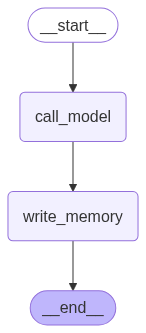

In [34]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [35]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Al Amin")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Al Amin
================================== Ai Message ==================================

Hello Al Amin! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [36]:
# User input
input_messages = [HumanMessage(content="How are you? you know, I like to bike around Bashundhara r/a, Dhaka.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

How are you? you know, I like to bike around Bashundhara r/a, Dhaka.
================================== Ai Message ==================================

I'm doing well, thanks for asking! I'm glad to hear that you enjoy biking around Bashundhara Residential Area in Dhaka. It's a great way to stay active and explore the local scenery. Bashundhara R/A is a beautiful place with plenty of greenery and scenic routes. Do you have a favorite route or spot that you like to visit while biking?


In [37]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Al Amin',
  'user_location': 'Bashundhara r/a, Dhaka',
  'interests': []},
 'created_at': '2025-05-19T12:13:01.470590+00:00',
 'updated_at': '2025-05-19T12:13:01.470590+00:00'}

In [38]:
existing_memory.value

{'user_name': 'Al Amin',
 'user_location': 'Bashundhara r/a, Dhaka',
 'interests': []}

In [39]:
# User input
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

That sounds delicious! Bakeries can be a great place to grab a quick snack or treat. Are you a fan of traditional Bangladeshi baked goods or do you prefer more Western-style pastries and bread? There are some great bakeries in and around Bashundhara R/A, I'm sure you've tried some of them. Do you have a favorite bakery or a go-to order?


In [40]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

As Al Amin from Bashundhara R/A, Dhaka, I'm happy to share some of my favorite bakeries with you! You know I'm a bit of a baking enthusiast, and I've tried out a few great spots around the city.

One of my top recommendations is Sidekicks Bakery & Café, located in Gulshan. They have an amazing selection of artisanal bread, pastries, and cakes. Their croissants are flaky and buttery, and their sandwiches are made with freshly baked bread.

Another favorite of mine is The Daily Loaf, a bakery and café with several locations around Dhaka, including one near my home in Bashundhara. They offer a wide variety of bread, including sourdough, baguettes, and ciabatta. Their cakes and pastries are also delicious, and they have a cozy atmosphere perfect for a quick breakfast or snack.

If you're lo

In [41]:
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Al Amin',
 'user_location': 'Bashundhara r/a, Dhaka',
 'interests': ['biking', 'bakeries']}